In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'unsw-nb15:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111554%2F267091%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T033441Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3ac2c7d6565145cb9940b80ea0d288f8a271a7fceabbfc506370bc15a5809dc3a56e9d55d6a29dab3940d3a22b4aeb7c834b78af606293735241d07238d98ecafb7416e0fe9bf883dc68317ae4d2276f2fb326a37c63c949ba922df5761b4c1d37f815b84060ea3b28dc85176224e69693a966d5144b5c3c21e240c8761f061f63366da6ac8fa615e8b1c149bb12e2d8eea17f85624c98693eb10869054ecab6b6a1c4cceb70c0b6cfb4c78391a9664c71fa84c939c1eae2796fef626293ccdc78b65dd871341bb8e4c50bc2719b6ea3da59933d4d1f0f681ccca58ef0b15dfbc155127cf5b700389cb4a52c2e5426f46fa00961c6817007b1f46b54a9e879ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 156257637 bytes downloaded
Downloaded and uncompressed: unsw-nb15
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb

import keras
from numpy import array
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Concatinate train and test to make some data precessing and cleaning before splitting**

In [3]:
df_train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df = pd.concat([df_train, df_test])
# information about the dataset
pd.set_option('display.max_columns', None)
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.700000,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.000000,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


**Get all Data with "Backdoor Attack"
and get 2329 Normal data as the same number as the Backdoor Attack**

In [4]:
# Filter the DataFrame to include only "Backdoor" and "Normal" rows
backdoor_data = df[df['attack_cat'] == 'Backdoor']
normal_data = df[df['attack_cat'] == 'Normal']

# Randomly sample 2329 rows from the "Normal" category
sampled_normal_data = normal_data.sample(n=2329, random_state=42)  # You can adjust the random_state if needed

# Combine the "Backdoor" and sampled "Normal" data
balanced_data = pd.concat([backdoor_data, sampled_normal_data])

# Shuffle the balanced data
balanced_data_shuffled = balanced_data.sample(frac=1, random_state=42)  # Shuffle with random_state for reproducibility
unique_sttl_values = balanced_data_shuffled['state'].unique()
unique_sttl_values

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

**Check Any missing Value**

In [5]:
# Check for missing values in the dataset
missing_values = balanced_data_shuffled.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)


Missing values in the dataset:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_

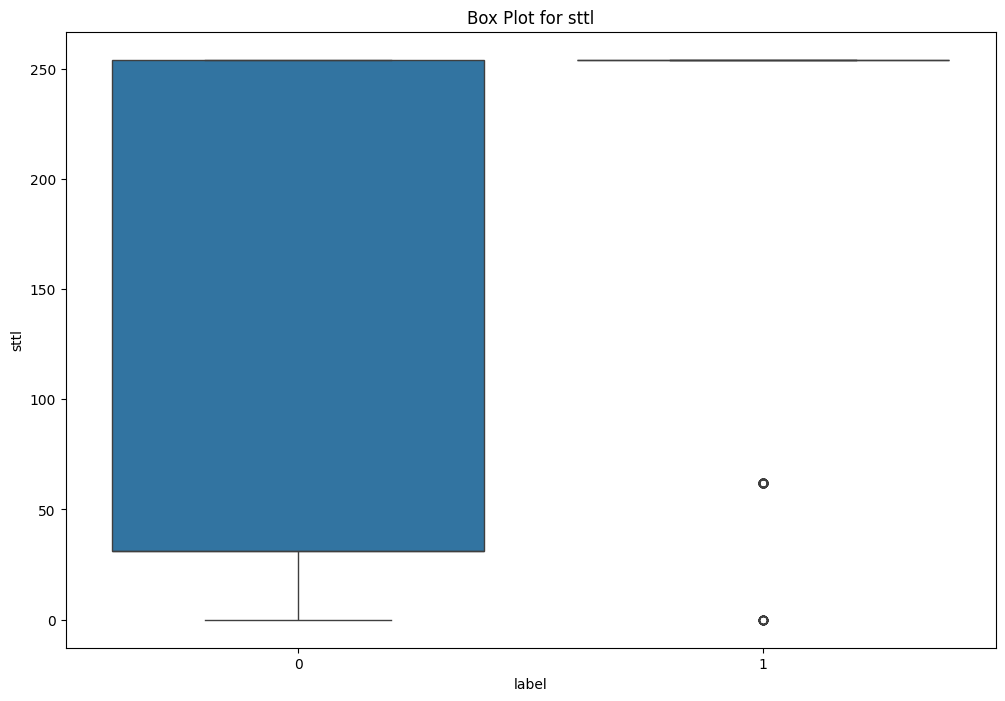

In [6]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.boxplot(x=target_variable, y=balanced_data_shuffled['sttl'], data=balanced_data_shuffled)
plt.title('Box Plot for sttl')
plt.show()


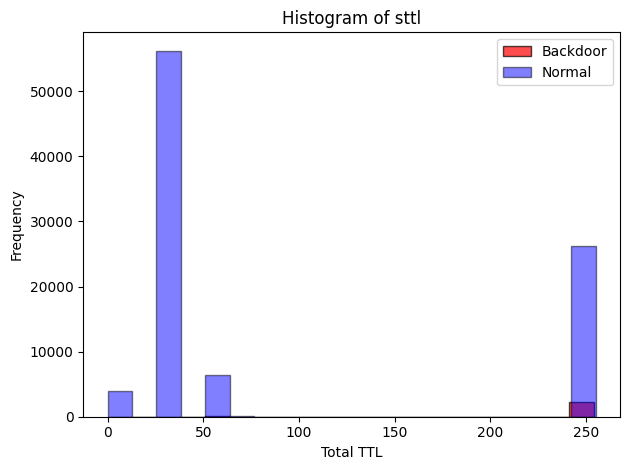

In [7]:

plt.hist(backdoor_data['sttl'], bins=20, color='red', alpha=0.7, label='Backdoor', edgecolor='black')
plt.hist(normal_data['sttl'], bins=20, color='blue', alpha=0.5, label='Normal', edgecolor='black')
plt.title('Histogram of sttl')
plt.xlabel('Total TTL')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

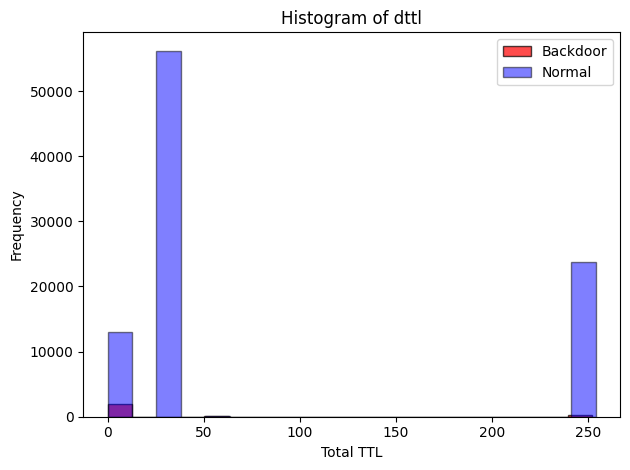

In [8]:
plt.hist(backdoor_data['dttl'], bins=20, color='red', alpha=0.7, label='Backdoor', edgecolor='black')
plt.hist(normal_data['dttl'], bins=20, color='blue', alpha=0.5, label='Normal', edgecolor='black')
plt.title('Histogram of dttl')
plt.xlabel('Total TTL')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

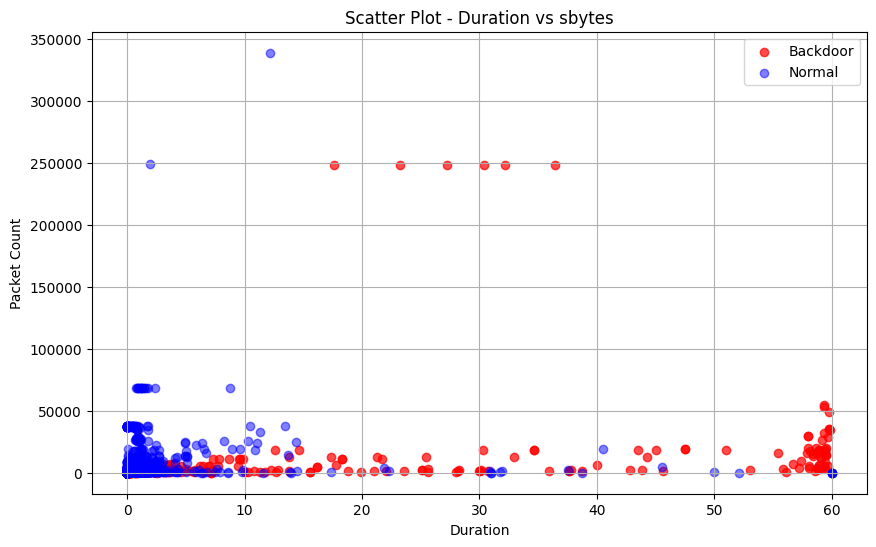

In [9]:
normal_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 0]
backdoor_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 1]
# Scatter plot for Duration vs Packet Count
plt.figure(figsize=(10, 6))

# Backdoor traffic
plt.scatter(backdoor_data['dur'], backdoor_data['sbytes'], color='red', label='Backdoor', alpha=0.7)

# Normal traffic
plt.scatter(normal_data['dur'], normal_data['sbytes'], color='blue', label='Normal', alpha=0.5)

plt.title('Scatter Plot - Duration vs sbytes')
plt.xlabel('Duration')
plt.ylabel('Packet Count')
plt.legend()
plt.grid(True)
plt.show()

['unas' 'nvp' 'ddx' 'pup' 'tcp' 'irtp' 'idpr' 'bna' 'ospf' 'sctp' 'snp'
 'vmtp' 'cpnx' 'a/n' 'any' 'zero' 'ip' 'leaf-1' 'kryptolan' 'compaq-peer'
 'ipcv' 'aes-sp3-d' 'pim' 'i-nlsp' 'ippc' 'mtp' 'sat-mon' 'hmp' 'xnet'
 'qnx' 'udp' 'ipx-n-ip' 'gre' 'wsn' 'uti' 'pipe' 'narp' 'argus' 'ipv6-no'
 'ib' 'xtp' 'emcon' 'vrrp' 'igp' 'tp++' 'iso-ip' 'cphb' 'ipnip' 'encap'
 'etherip' 'ipv6-route' 'l2tp' 'crudp' 'trunk-1' 'rvd' 'sat-expak'
 'mobile' 'prm' 'eigrp' 'rsvp' 'pgm' 'merit-inp' 'sdrp' 'sep' 'ipv6'
 'ax.25' 'smp' 'sun-nd' 'iplt' 'netblt' 'fire' 'isis' 'wb-expak' 'srp'
 'idrp' 'rdp' 'trunk-2' 'ipip' 'skip' 'sprite-rpc' 'bbn-rcc' 'ipv6-opts'
 'visa' 'dgp' 'mhrp' 'leaf-2' 'iatp' 'br-sat-mon' 'iso-tp4' 'cftp' 'ddp'
 'pnni' 'nsfnet-igp' 'sps' 'chaos' 'sccopmce' 'secure-vmtp' 'ggp' 'scps'
 'dcn' 'tcf' 'tlsp' 'wb-mon' 'crtp' '3pc' 'stp' 'swipe' 'cbt' 'sm' 'pvp'
 'ttp' 'egp' 'ipcomp' 'ptp' 'larp' 'ipv6-frag' 'idpr-cmtp' 'st2' 'vines'
 'fc' 'aris' 'mux' 'pri-enc' 'gmtp' 'micp' 'ifmp' 'mfe-nsp' 'xns-

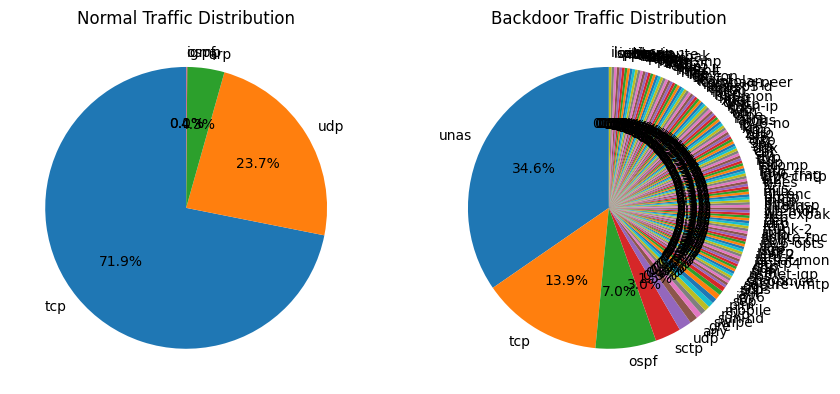

In [10]:
normal_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 0]['proto'].value_counts()
print ( balanced_data_shuffled[balanced_data_shuffled['label'] == 1]['proto'].unique())
backdoor_data = balanced_data_shuffled[balanced_data_shuffled['label'] == 1]['proto'].value_counts()

# Calculate percentages
total_normal = normal_data.sum()
normal_percentages = [(count / total_normal) * 100 for count in normal_data]

total_backdoor = backdoor_data.sum()
backdoor_percentages = [(count / total_backdoor) * 100 for count in backdoor_data]

# Create Pie Charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Pie chart for Normal Traffic
axes[0].pie(normal_percentages, labels=normal_data.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Normal Traffic Distribution')

# Pie chart for Backdoor Traffic
axes[1].pie(backdoor_percentages, labels=backdoor_data.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Backdoor Traffic Distribution')

plt.show()


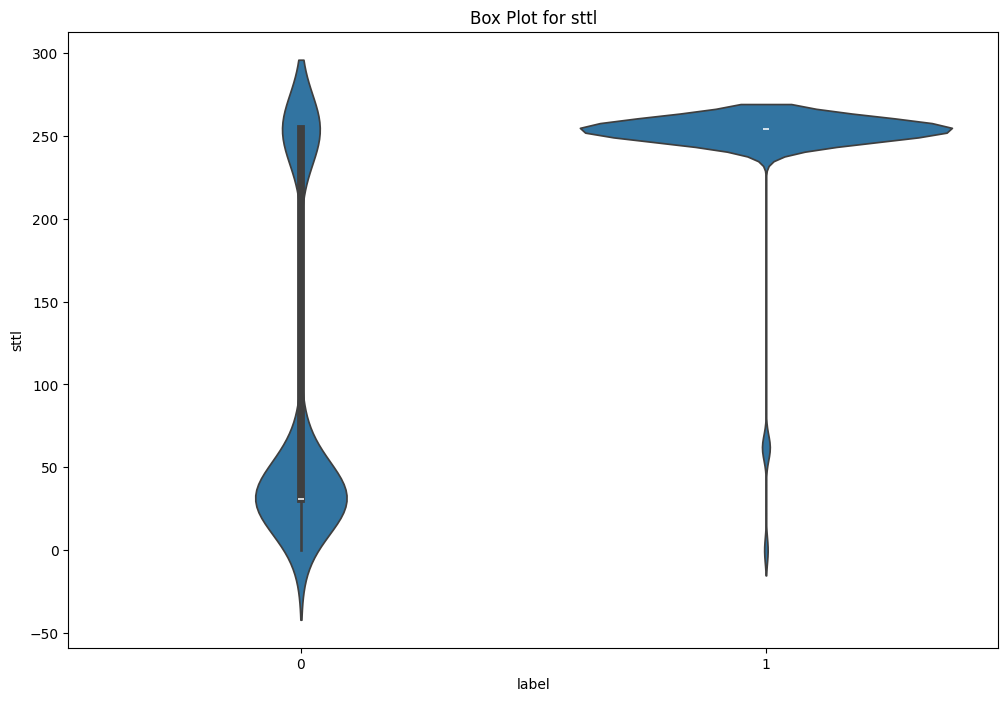

In [11]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.violinplot(x=target_variable, y=balanced_data_shuffled['sttl'], data=balanced_data_shuffled)
plt.title('Box Plot for sttl')
plt.show()


In [12]:
unique_sttl_values = balanced_data_shuffled['ackdat'].unique()
unique_sttl_values

array([0.      , 0.000129, 0.000161, ..., 0.06085 , 0.054865, 0.125041])

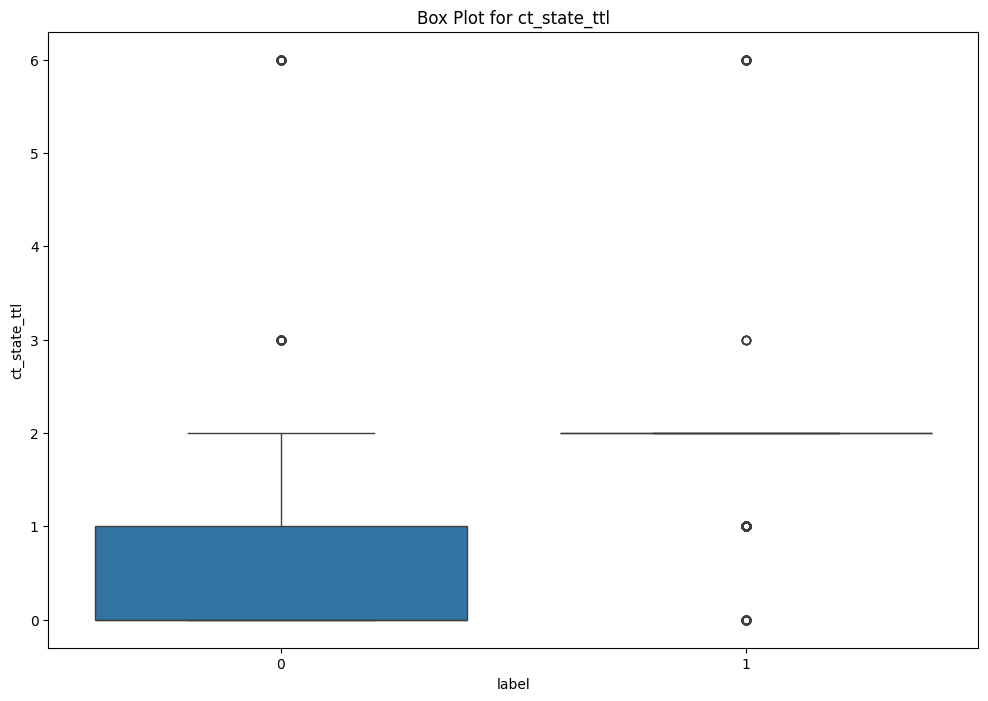

In [13]:
target_variable = balanced_data_shuffled['label']
plt.figure(figsize=(12, 8))
sns.boxplot(x=target_variable, y=balanced_data_shuffled['ct_state_ttl'], data=balanced_data_shuffled)
plt.title('Box Plot for ct_state_ttl')
plt.show()


In [14]:
unique_sttl_values = balanced_data_shuffled['state'].unique()
unique_sttl_values

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

In [15]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [16]:
import pandas as pd
import statsmodels.api as sm

# Assuming your DataFrame is named 'df'
# Replace 'YourColumnName' with the actual column names in your DataFrame

# Select the columns of interest
selected_columns = ['state', 'sttl', 'dttl', 'ct_state_ttl']

# Create a new DataFrame with only the selected columns
selected_df = balanced_data_shuffled[selected_columns]

# Convert 'state' column to numeric
selected_df['state'] = pd.to_numeric(selected_df['state'], errors='coerce')

# Encode categorical variable 'state' into numerical values
selected_df = pd.get_dummies(selected_df, columns=['state'], prefix='state', drop_first=True)

# Convert all columns to numeric, handle any non-numeric values
selected_df = selected_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
selected_df = selected_df.dropna()

# Add a constant term for the intercept
selected_df = sm.add_constant(selected_df)

# Separate independent variables (X) and dependent variable (y)
X = selected_df.drop('ct_state_ttl', axis=1)  # Exclude the dependent variable
y = selected_df['ct_state_ttl']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           ct_state_ttl   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     2074.
Date:                Thu, 04 Jul 2024   Prob (F-statistic):               0.00
Time:                        03:54:16   Log-Likelihood:                -5835.8
No. Observations:                4658   AIC:                         1.168e+04
Df Residuals:                    4655   BIC:                         1.170e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2183      0.024      9.100      0.0

<ipython-input-16-0718612f28ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['state'] = pd.to_numeric(selected_df['state'], errors='coerce')


**Drop unecessary Features**

In [17]:
# # Drop features that don't belong to the "Backdoor" attack category
# balanced_data_shuffled =  balanced_data_shuffled.drop(['swin', 'dwin', 'stcpb', 'dtcpb',
#            'trans_depth', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
#            'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
#            'attack_cat','id'], axis=1)
# balanced_data_shuffled.info()
# Drop features that don't belong to the "Backdoor" attack category
balanced_data_shuffled =  balanced_data_shuffled.drop(['attack_cat','id'], axis=1)
balanced_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                4658 non-null   float64
 1   proto              4658 non-null   object 
 2   service            4658 non-null   object 
 3   state              4658 non-null   object 
 4   spkts              4658 non-null   int64  
 5   dpkts              4658 non-null   int64  
 6   sbytes             4658 non-null   int64  
 7   dbytes             4658 non-null   int64  
 8   rate               4658 non-null   float64
 9   sttl               4658 non-null   int64  
 10  dttl               4658 non-null   int64  
 11  sload              4658 non-null   float64
 12  dload              4658 non-null   float64
 13  sloss              4658 non-null   int64  
 14  dloss              4658 non-null   int64  
 15  sinpkt             4658 non-null   float64
 16  dinpkt             4658

Shuffel

In [18]:
balanced_data_shuffled['service'].unique() #Here, we'll deal with the type of service that is '-'
balanced_data_shuffled['service']= np.where(balanced_data_shuffled['service'] == '-', 'None', balanced_data_shuffled['service'])
print(balanced_data_shuffled['service'].unique())


['None' 'dns' 'ftp' 'smtp' 'http' 'ftp-data' 'irc' 'ssh']


In [19]:
balanced_data_shuffled['proto'].unique() #This is definitely a categorical feature.

array(['unas', 'tcp', 'nvp', 'udp', 'arp', 'ddx', 'pup', 'irtp', 'idpr',
       'bna', 'ospf', 'sctp', 'snp', 'vmtp', 'cpnx', 'a/n', 'any', 'zero',
       'ip', 'leaf-1', 'kryptolan', 'compaq-peer', 'ipcv', 'aes-sp3-d',
       'pim', 'i-nlsp', 'ippc', 'mtp', 'sat-mon', 'hmp', 'xnet', 'qnx',
       'ipx-n-ip', 'gre', 'wsn', 'uti', 'pipe', 'narp', 'argus',
       'ipv6-no', 'ib', 'xtp', 'emcon', 'vrrp', 'igp', 'tp++', 'iso-ip',
       'cphb', 'ipnip', 'encap', 'etherip', 'igmp', 'ipv6-route', 'l2tp',
       'crudp', 'trunk-1', 'rvd', 'sat-expak', 'mobile', 'prm', 'eigrp',
       'rsvp', 'pgm', 'merit-inp', 'sdrp', 'sep', 'ipv6', 'ax.25', 'smp',
       'sun-nd', 'iplt', 'netblt', 'fire', 'isis', 'wb-expak', 'srp',
       'idrp', 'rdp', 'trunk-2', 'ipip', 'skip', 'sprite-rpc', 'bbn-rcc',
       'ipv6-opts', 'visa', 'dgp', 'mhrp', 'leaf-2', 'iatp', 'br-sat-mon',
       'iso-tp4', 'cftp', 'ddp', 'pnni', 'nsfnet-igp', 'sps', 'chaos',
       'sccopmce', 'secure-vmtp', 'ggp', 'scps', 'dcn', 'tc

In [20]:
balanced_data_shuffled['state'].unique() #Keep it.

array(['INT', 'FIN', 'CON', 'REQ', 'RST'], dtype=object)

In [21]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [22]:
cols = balanced_data_shuffled.columns
data_bin = Remove_dump_values(balanced_data_shuffled, cols)

 **I need OneHotEncoding Proto, Service, state**

In [23]:
df_cat = data_bin.select_dtypes(exclude=[np.number])
from sklearn.preprocessing import LabelEncoder
import joblib

# Assuming df_cat is your DataFrame with categorical columns
for feature in df_cat.columns:
    le = LabelEncoder()
    data_bin[feature] = le.fit_transform(data_bin[feature])

    # Save the LabelEncoder
    encoder_filename = f'{feature}_encoder.joblib'
    joblib.dump(le, encoder_filename)

# Now you can use encoder_filename to load the encoder later

In [24]:
data_bin.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
109826,2393,118,0,2,20,0,161,0,1015,2,0,762,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,2,17,11,5,33,0,0,0,20,32,0,1
5930,499,111,0,1,16,15,107,133,570,4,2,2100,1876,24,37,560,542,1920,875,1,1262,217,1,33,17,26,245,212,0,0,5,0,28,17,0,1,0,0,0,32,3,0,0
4293,2463,111,0,1,64,60,193,22,757,4,2,1161,285,22,36,922,1746,1653,1355,1,1365,339,1,288,228,58,154,28,0,0,37,0,29,8,0,35,0,0,0,20,3,0,0
50552,2012,76,0,2,20,0,132,0,2466,2,0,2169,0,0,0,11,0,0,0,0,0,0,0,0,0,0,235,0,0,0,38,2,11,8,3,11,0,0,0,11,34,0,1
27365,500,111,0,1,16,15,107,133,569,4,2,2098,1874,24,37,561,544,1919,890,1,33,1069,1,26,16,20,245,212,0,0,35,0,26,17,0,35,0,0,0,32,35,0,0


**Corrolation Matrix**

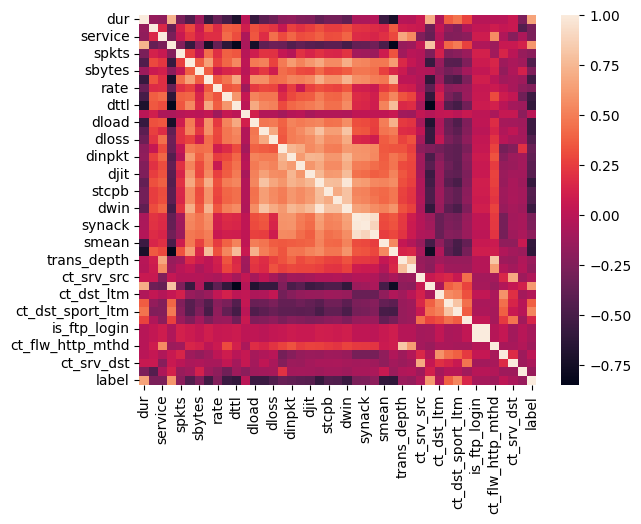

In [25]:
sns.heatmap(data_bin.corr())
plt.show()

In [26]:
columns = data_bin.columns.tolist()
corr = data_bin.corr()
correlated_vars = []
for i in range(len(columns) - 1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.95:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

swin dwin 0.9717936124274676
tcprtt synack 0.9828973866750446
is_ftp_login ct_ftp_cmd 1.0


In [27]:
data_bin = data_bin.drop(columns=correlated_vars)
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   dur                4658 non-null   int64
 1   proto              4658 non-null   int64
 2   service            4658 non-null   int64
 3   state              4658 non-null   int64
 4   spkts              4658 non-null   int64
 5   dpkts              4658 non-null   int64
 6   sbytes             4658 non-null   int64
 7   dbytes             4658 non-null   int64
 8   rate               4658 non-null   int64
 9   sttl               4658 non-null   int64
 10  dttl               4658 non-null   int64
 11  sload              4658 non-null   int64
 12  dload              4658 non-null   int64
 13  sloss              4658 non-null   int64
 14  dloss              4658 non-null   int64
 15  sinpkt             4658 non-null   int64
 16  dinpkt             4658 non-null   int64
 17  sjit         

**Mutual Information**

In [28]:
x = data_bin.drop(columns=['label'])
y = data_bin['label']

In [29]:
mi_scores = mutual_info_classif(x, y)
mi_df = pd.DataFrame(mi_scores, index=x.columns, columns=['MI Score'])
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

print(mi_df)

                   MI Score
sttl               0.327026
dttl               0.286671
state              0.280733
ct_state_ttl       0.280321
dur                0.229297
dbytes             0.212076
ct_dst_sport_ltm   0.198208
swin               0.184312
dmean              0.176455
sloss              0.170125
smean              0.167500
sbytes             0.151906
dload              0.144671
proto              0.120096
djit               0.105108
dtcpb              0.101872
dloss              0.095446
stcpb              0.089793
dpkts              0.080821
ct_src_dport_ltm   0.076125
sjit               0.074997
dinpkt             0.060002
spkts              0.059024
rate               0.052819
service            0.034447
ct_dst_src_ltm     0.033650
sinpkt             0.028059
response_body_len  0.019727
ct_flw_http_mthd   0.017947
ackdat             0.015852
tcprtt             0.013220
trans_depth        0.012275
sload              0.010114
ct_srv_src         0.007704
ct_dst_ltm         0

<ipython-input-30-857cbf82e5cd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI Score', y=mi_df_sorted.index, data=mi_df_sorted, palette='mako')


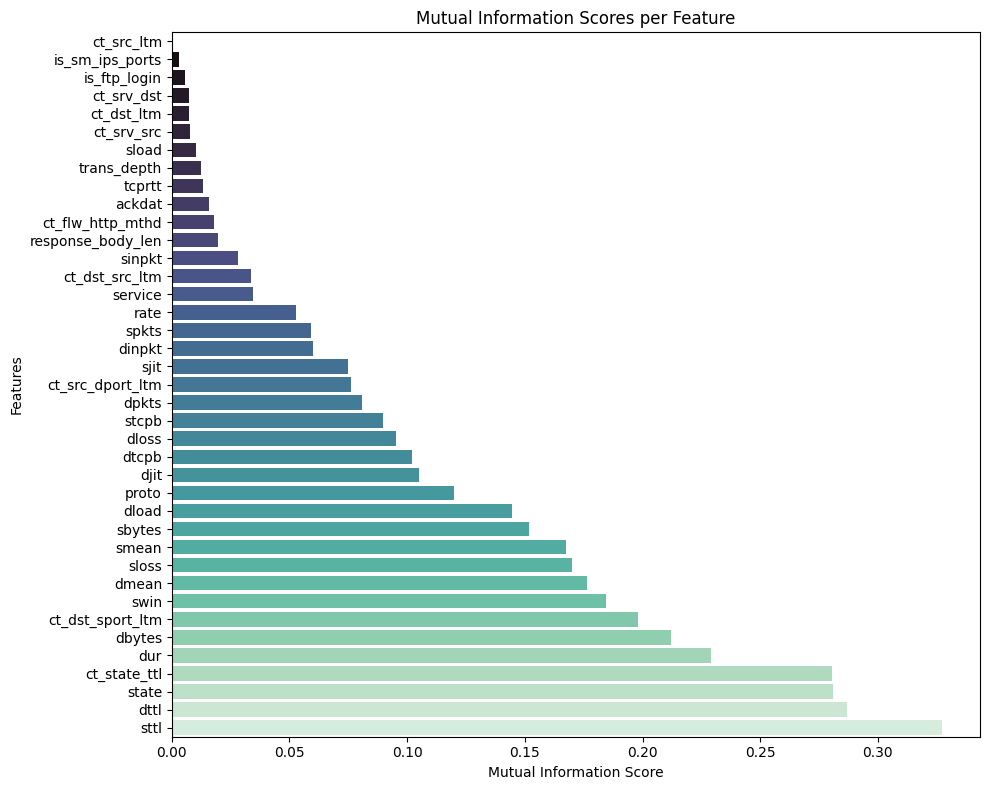

In [30]:
mi_df_sorted = mi_df.sort_values(by='MI Score', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='MI Score', y=mi_df_sorted.index, data=mi_df_sorted, palette='mako')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores per Feature')
plt.tight_layout()
plt.show()

In [31]:
data_bin =  data_bin.drop(['trans_depth','ct_src_ltm','tcprtt','rate','ct_state_ttl'], axis=1)
data_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4658 entries, 109826 to 90614
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   dur                4658 non-null   int64
 1   proto              4658 non-null   int64
 2   service            4658 non-null   int64
 3   state              4658 non-null   int64
 4   spkts              4658 non-null   int64
 5   dpkts              4658 non-null   int64
 6   sbytes             4658 non-null   int64
 7   dbytes             4658 non-null   int64
 8   sttl               4658 non-null   int64
 9   dttl               4658 non-null   int64
 10  sload              4658 non-null   int64
 11  dload              4658 non-null   int64
 12  sloss              4658 non-null   int64
 13  dloss              4658 non-null   int64
 14  sinpkt             4658 non-null   int64
 15  dinpkt             4658 non-null   int64
 16  sjit               4658 non-null   int64
 17  djit         

**Splitting training and testing sets**

In [32]:
selected_columns = ['dur', 'proto', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'dload', 'sloss', 'dinpkt', 'ackdat', 'smean', 'dmean', 'ct_srv_src',
       'ct_dst_src_ltm', 'ct_srv_dst','label']

dtt = data_bin[selected_columns]
X = dtt.drop(columns=['label'])
feature_list = list(X.columns)
X = np.array(X)
y = dtt['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


In [33]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Training set: 3493
Testing set: 1165


# **Algorithms**

In [34]:
params = {
    'max_depth': 10,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 2,                # Number of classes
    'n_gpus': 4
}
models = {}
models['Decision Tree Classifier'] = DecisionTreeClassifier()
models['Random Forest Classifier'] =random_forest= RandomForestClassifier()
models['Gaussian Naive Bayes'] = GaussianNB()
models['xgb_classifier'] = xgb_classifier = xgb.XGBClassifier(**params)

In [35]:
train_score, accuracy, precision, recall, training_time, y_pred = {}, {}, {}, {}, {}, {}
for key in models.keys():
    start_time = time.time()
    models[key].fit(X_train, y_train)
    training_time[key] = time.time() - start_time
    y_pred[key] = models[key].predict(X_test)
    train_score[key] = models[key].score(X_train, y_train)
    accuracy[key] = models[key].score(X_test, y_test)
    precision[key] = precision_score(y_test, y_pred[key])
    recall[key] = recall_score(y_test, y_pred[key])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:54:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
df_models = pd.DataFrame(index=models.keys(), columns=['Training score', 'Accuracy', 'Precision', 'Recall', 'Training time'])
df_models['Training score'] = train_score.values()
df_models['Accuracy'] = accuracy.values()
df_models['Precision'] = precision.values()
df_models['Recall'] = recall.values()
df_models['Training time'] = training_time.values()

In [37]:
df_models

,Training score,Accuracy,Precision,Recall,Training time
Decision Tree Classifier,1.000000,0.970815,0.960345,0.980634,0.021585
Random Forest Classifier,1.000000,0.980258,0.975567,0.984155,0.419535
Gaussian Naive Bayes,0.853707,0.848927,0.857664,0.827465,0.002205
xgb_classifier,1.000000,0.978541,0.977153,0.978873,2.819196


In [38]:
joblib.dump(random_forest, 'random_forest.joblib')
joblib.dump(xgb_classifier, 'xgb_classifier.joblib')

['xgb_classifier.joblib']

**Random Forest Classifier + Recursive Feature Elimination**

In [39]:
rfc_rfe = 'Random Forest Classifier + Recursive Feature Elimination'
models[rfc_rfe] = RandomForestClassifier()
rfe = RFE(models[rfc_rfe])
start_time = time.time()
rfe.fit(X_train, y_train)
training_time[rfc_rfe] = time.time() - start_time

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

start_time = time.time()
models[rfc_rfe].fit(X_train_rfe, y_train)
training_time[rfc_rfe] = training_time[rfc_rfe] + (time.time() - start_time)

y_pred[key] = models[rfc_rfe].predict(X_test_rfe)

train_score[rfc_rfe] = models[rfc_rfe].score(X_train_rfe, y_train)
accuracy[rfc_rfe] = models[rfc_rfe].score(X_test_rfe, y_test)
precision[rfc_rfe] = precision_score(y_test, y_pred[key])
recall[rfc_rfe] = recall_score(y_test, y_pred[key])

Old number of features: 15
New number of features: 7
Selected Features: Index(['proto', 'state', 'dpkts', 'sttl', 'sload', 'dload', 'sinpkt'], dtype='object')


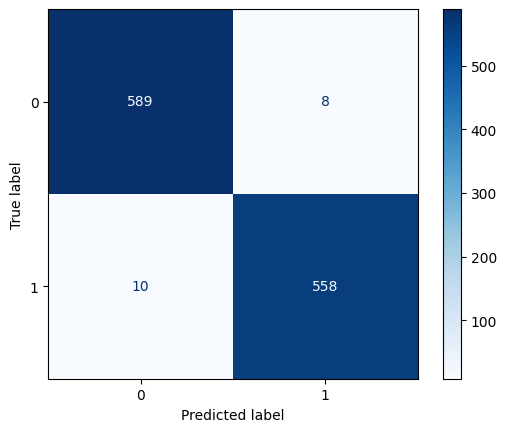

In [40]:
print("Old number of features:", X.shape[1])
print("New number of features:", len(rfe.estimator_.feature_importances_))
#print("new features:",rfe.estimator_.feature_importances_)
# Access the support_ attribute to get the boolean mask of selected features
selected_features_mask = rfe.support_
test = data_bin.drop(columns=['label'])
# Get the indices of the selected features
selected_feature_indices = [i for i, selected in enumerate(selected_features_mask) if selected]

# Get the names of the selected features (assuming X_train is a NumPy array)
selected_feature_names = test.columns[selected_feature_indices]

# Print or use the selected feature names as needed
print("Selected Features:", selected_feature_names)

y_pred[key] = models[rfc_rfe].predict(X_test_rfe)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred[key], labels=models[rfc_rfe].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=models[rfc_rfe].classes_)
disp.plot(cmap='Blues')
plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Assuming 'models' is a dictionary of classifiers


# Assuming 'data_bin' is your DataFrame
X = dtt.drop(columns=['label'])
feature_list = list(X.columns)
X = np.array(X)
y = dtt['label'].values  # Convert to NumPy array
assert X.shape[0] == y.shape[0], "X and y must have the same number of rows"

# Check for missing values
assert not np.isnan(X).any(), "X contains missing values"
assert not pd.isnull(y).any(), "y contains missing values"

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recall_scores = []
f1_scores = []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Your training and testing code goes here
    random_forest.fit(X_train, y_train)
    accuracy = random_forest.score(X_test, y_test)
    y_pred =random_forest.predict(X_test)
    print(f'Accuracy: {accuracy}')

    # Calculate recall and F1 score
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append scores to lists
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print scores for each fold
    print(f'Fold - Recall: {recall:.4f}, F1 Score: {f1:.4f}')



Accuracy: 0.9871244635193133
Fold - Recall: 0.9871, F1 Score: 0.9871
Accuracy: 0.990343347639485
Fold - Recall: 0.9957, F1 Score: 0.9904
Accuracy: 0.9828326180257511
Fold - Recall: 0.9785, F1 Score: 0.9828
Accuracy: 0.9892588614393125
Fold - Recall: 0.9871, F1 Score: 0.9892
Accuracy: 0.99140708915145
Fold - Recall: 0.9978, F1 Score: 0.9915


In [42]:
joblib.dump(random_forest, 'stratified_random_forest.joblib')

['stratified_random_forest.joblib']

# **LSTM**

In [43]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Assuming X_train, y_train, X_val, and y_val are defined elsewhere in your code

# Preprocess data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.joblib')



# Reshape data for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# Build LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))  # Adding dropout for regularization
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model with an adaptive learning rate
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
start_time = time.time()
history = lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])
end_time = time.time()

# Evaluate the model on the test set
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

test_loss, test_accuracy = lstm_model.evaluate(X_test_reshaped, y_test)

# Calculate additional metrics
y_pred = lstm_model.predict(X_test_reshaped)
y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming binary classification
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)




Epoch 1/100
111/117 [===========================>..] - ETA: 0s - loss: 0.4864 - accuracy: 0.8376

117/117 [==============================] - 4s 5ms/step - loss: 0.4798 - accuracy: 0.8377
Epoch 2/100
111/117 [===========================>..] - ETA: 0s - loss: 0.2591 - accuracy: 0.8781

117/117 [==============================] - 1s 5ms/step - loss: 0.2575 - accuracy: 0.8795
Epoch 3/100
115/117 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9057

117/117 [==============================] - 1s 5ms/step - loss: 0.2114 - accuracy: 0.9056
Epoch 4/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1858 - accuracy: 0.9194

117/117 [==============================] - 1s 6ms/step - loss: 0.1857 - accuracy: 0.9190
Epoch 5/100
111/117 [===========================>..] - ETA: 0s - loss: 0.1755 - accuracy: 0.9291

117/117 [==============================] - 1s 6ms/step - loss: 0.1758 - accuracy: 0.9273
Epoch 6/100
114/117 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9361

117/117 [==============================] - 1s 7ms/step - loss: 0.1656 - accuracy: 0.9364
Epoch 7/100
116/117 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9345

117/117 [==============================] - 1s 6ms/step - loss: 0.1607 - accuracy: 0.9345
Epoch 8/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1608 - accuracy: 0.9403

117/117 [==============================] - 1s 5ms/step - loss: 0.1604 - accuracy: 0.9404
Epoch 9/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1542 - accuracy: 0.9408

117/117 [==============================] - 1s 5ms/step - loss: 0.1572 - accuracy: 0.9399
Epoch 10/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1523 - accuracy: 0.9450

117/117 [==============================] - 1s 5ms/step - loss: 0.1547 - accuracy: 0.9442
Epoch 11/100
114/117 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9408

117/117 [==============================] - 1s 5ms/step - loss: 0.1524 - accuracy: 0.9412
Epoch 12/100
109/117 [==========================>...] - ETA: 0s - loss: 0.1548 - accuracy: 0.9429

117/117 [==============================] - 1s 5ms/step - loss: 0.1526 - accuracy: 0.9431
Epoch 13/100
116/117 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9423

117/117 [==============================] - 1s 5ms/step - loss: 0.1498 - accuracy: 0.9426
Epoch 14/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1498 - accuracy: 0.9422

117/117 [==============================] - 1s 5ms/step - loss: 0.1478 - accuracy: 0.9434
Epoch 15/100
107/117 [==========================>...] - ETA: 0s - loss: 0.1482 - accuracy: 0.9430

117/117 [==============================] - 1s 5ms/step - loss: 0.1467 - accuracy: 0.9439
Epoch 16/100
110/117 [===========================>..] - ETA: 0s - loss: 0.1467 - accuracy: 0.9412

117/117 [==============================] - 1s 5ms/step - loss: 0.1437 - accuracy: 0.9428
Epoch 17/100
116/117 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9485

117/117 [==============================] - 0s 4ms/step - loss: 0.1397 - accuracy: 0.9485
Epoch 18/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1389 - accuracy: 0.9463

117/117 [==============================] - 1s 5ms/step - loss: 0.1399 - accuracy: 0.9463
Epoch 19/100
108/117 [==========================>...] - ETA: 0s - loss: 0.1382 - accuracy: 0.9491

117/117 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9493
Epoch 20/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1330 - accuracy: 0.9501

117/117 [==============================] - 1s 5ms/step - loss: 0.1333 - accuracy: 0.9504
Epoch 21/100
115/117 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9500

117/117 [==============================] - 1s 5ms/step - loss: 0.1302 - accuracy: 0.9501
Epoch 22/100
111/117 [===========================>..] - ETA: 0s - loss: 0.1312 - accuracy: 0.9496

117/117 [==============================] - 1s 4ms/step - loss: 0.1305 - accuracy: 0.9493
Epoch 23/100
111/117 [===========================>..] - ETA: 0s - loss: 0.1266 - accuracy: 0.9527

117/117 [==============================] - 1s 4ms/step - loss: 0.1296 - accuracy: 0.9514
Epoch 24/100
117/117 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9549

117/117 [==============================] - 1s 5ms/step - loss: 0.1233 - accuracy: 0.9549
Epoch 25/100
116/117 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9526

117/117 [==============================] - 1s 7ms/step - loss: 0.1211 - accuracy: 0.9522
Epoch 26/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1184 - accuracy: 0.9549

117/117 [==============================] - 1s 6ms/step - loss: 0.1187 - accuracy: 0.9544
Epoch 27/100
114/117 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9567

117/117 [==============================] - 1s 7ms/step - loss: 0.1138 - accuracy: 0.9565
Epoch 28/100
110/117 [===========================>..] - ETA: 0s - loss: 0.1132 - accuracy: 0.9557

117/117 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.9555
Epoch 29/100
109/117 [==========================>...] - ETA: 0s - loss: 0.1107 - accuracy: 0.9570

117/117 [==============================] - 1s 5ms/step - loss: 0.1130 - accuracy: 0.9565
Epoch 30/100
115/117 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9573

117/117 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 0.9565
Epoch 31/100
110/117 [===========================>..] - ETA: 0s - loss: 0.1168 - accuracy: 0.9528

117/117 [==============================] - 1s 5ms/step - loss: 0.1141 - accuracy: 0.9536
Epoch 32/100
108/117 [==========================>...] - ETA: 0s - loss: 0.1062 - accuracy: 0.9618

117/117 [==============================] - 1s 4ms/step - loss: 0.1053 - accuracy: 0.9614
Epoch 33/100
117/117 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9600

117/117 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9600
Epoch 34/100
111/117 [===========================>..] - ETA: 0s - loss: 0.1029 - accuracy: 0.9600

117/117 [==============================] - 1s 4ms/step - loss: 0.1044 - accuracy: 0.9592
Epoch 35/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1026 - accuracy: 0.9601

117/117 [==============================] - 1s 5ms/step - loss: 0.1017 - accuracy: 0.9608
Epoch 36/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1032 - accuracy: 0.9607

117/117 [==============================] - 1s 7ms/step - loss: 0.1031 - accuracy: 0.9603
Epoch 37/100
117/117 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9622

117/117 [==============================] - 1s 7ms/step - loss: 0.1013 - accuracy: 0.9622
Epoch 38/100
113/117 [===========================>..] - ETA: 0s - loss: 0.1029 - accuracy: 0.9613

117/117 [==============================] - 1s 6ms/step - loss: 0.1013 - accuracy: 0.9622
Epoch 39/100
107/117 [==========================>...] - ETA: 0s - loss: 0.1008 - accuracy: 0.9609

117/117 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9616
Epoch 40/100
108/117 [==========================>...] - ETA: 0s - loss: 0.0969 - accuracy: 0.9621

117/117 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9632
Epoch 41/100
109/117 [==========================>...] - ETA: 0s - loss: 0.0969 - accuracy: 0.9633

117/117 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9640
Epoch 42/100
117/117 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9614

117/117 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9614
Epoch 43/100
114/117 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9619

117/117 [==============================] - 1s 5ms/step - loss: 0.0938 - accuracy: 0.9619
Epoch 44/100
108/117 [==========================>...] - ETA: 0s - loss: 0.0865 - accuracy: 0.9661

117/117 [==============================] - 1s 6ms/step - loss: 0.0916 - accuracy: 0.9643
Epoch 45/100
116/117 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9644

117/117 [==============================] - 1s 6ms/step - loss: 0.0919 - accuracy: 0.9646
Epoch 46/100
114/117 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9655

117/117 [==============================] - 1s 7ms/step - loss: 0.0934 - accuracy: 0.9651
Epoch 47/100
111/117 [===========================>..] - ETA: 0s - loss: 0.0907 - accuracy: 0.9631

117/117 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9624
Epoch 48/100
106/117 [==========================>...] - ETA: 0s - loss: 0.0903 - accuracy: 0.9658

117/117 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9662
Epoch 49/100
111/117 [===========================>..] - ETA: 0s - loss: 0.0912 - accuracy: 0.9657

117/117 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.9651
Epoch 50/100
114/117 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.9638

117/117 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9640
Epoch 51/100
110/117 [===========================>..] - ETA: 0s - loss: 0.0909 - accuracy: 0.9639

117/117 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9635
Epoch 52/100
115/117 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9658

117/117 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.9662
Epoch 53/100
113/117 [===========================>..] - ETA: 0s - loss: 0.0879 - accuracy: 0.9665

117/117 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9662
Epoch 54/100
107/117 [==========================>...] - ETA: 0s - loss: 0.0882 - accuracy: 0.9655

117/117 [==============================] - 0s 4ms/step - loss: 0.0878 - accuracy: 0.9654
Epoch 55/100
115/117 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9660

117/117 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9662
Epoch 56/100
105/117 [=========================>....] - ETA: 0s - loss: 0.0860 - accuracy: 0.9682

117/117 [==============================] - 1s 4ms/step - loss: 0.0848 - accuracy: 0.9686
Epoch 57/100
116/117 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9677

117/117 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9675
Epoch 58/100
112/117 [===========================>..] - ETA: 0s - loss: 0.0833 - accuracy: 0.9685

117/117 [==============================] - 1s 4ms/step - loss: 0.0842 - accuracy: 0.9683
Epoch 59/100
114/117 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9671

117/117 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9678
Epoch 60/100
111/117 [===========================>..] - ETA: 0s - loss: 0.0798 - accuracy: 0.9693

117/117 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9691
Epoch 61/100
110/117 [===========================>..] - ETA: 0s - loss: 0.0831 - accuracy: 0.9651

117/117 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9651
Epoch 62/100
116/117 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9685

117/117 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9686
Epoch 63/100
111/117 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9673

117/117 [==============================] - 1s 4ms/step - loss: 0.0816 - accuracy: 0.9681
Epoch 64/100
109/117 [==========================>...] - ETA: 0s - loss: 0.0800 - accuracy: 0.9679

117/117 [==============================] - 0s 4ms/step - loss: 0.0789 - accuracy: 0.9678
Epoch 65/100
112/117 [===========================>..] - ETA: 0s - loss: 0.0794 - accuracy: 0.9707

117/117 [==============================] - 1s 5ms/step - loss: 0.0798 - accuracy: 0.9705
Epoch 66/100
116/117 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9723

117/117 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9716
Epoch 67/100
106/117 [==========================>...] - ETA: 0s - loss: 0.0747 - accuracy: 0.9732

117/117 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 0.9718
Epoch 68/100
115/117 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.9698

117/117 [==============================] - 1s 6ms/step - loss: 0.0771 - accuracy: 0.9699
Epoch 69/100
115/117 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9701

117/117 [==============================] - 1s 6ms/step - loss: 0.0757 - accuracy: 0.9705
Epoch 70/100
116/117 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9714

117/117 [==============================] - 1s 5ms/step - loss: 0.0767 - accuracy: 0.9716
Epoch 71/100
113/117 [===========================>..] - ETA: 0s - loss: 0.0750 - accuracy: 0.9699

117/117 [==============================] - 1s 6ms/step - loss: 0.0754 - accuracy: 0.9697
Epoch 72/100
112/117 [===========================>..] - ETA: 0s - loss: 0.0757 - accuracy: 0.9704

117/117 [==============================] - 1s 5ms/step - loss: 0.0739 - accuracy: 0.9713
Epoch 73/100
107/117 [==========================>...] - ETA: 0s - loss: 0.0737 - accuracy: 0.9714

117/117 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9705
Epoch 74/100
112/117 [===========================>..] - ETA: 0s - loss: 0.0746 - accuracy: 0.9707

117/117 [==============================] - 1s 4ms/step - loss: 0.0745 - accuracy: 0.9705
Epoch 75/100
115/117 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9715

117/117 [==============================] - 1s 5ms/step - loss: 0.0743 - accuracy: 0.9718
Epoch 76/100
104/117 [=========================>....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9718

117/117 [==============================] - 1s 4ms/step - loss: 0.0712 - accuracy: 0.9716
Epoch 77/100
117/117 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9732

117/117 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9732
Epoch 78/100
105/117 [=========================>....] - ETA: 0s - loss: 0.0722 - accuracy: 0.9696

117/117 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.9710
Epoch 79/100
117/117 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9713

117/117 [==============================] - 0s 4ms/step - loss: 0.0757 - accuracy: 0.9713
Epoch 80/100
110/117 [===========================>..] - ETA: 0s - loss: 0.0707 - accuracy: 0.9716

117/117 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9718
Epoch 81/100
109/117 [==========================>...] - ETA: 0s - loss: 0.0711 - accuracy: 0.9713

117/117 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.9716
Epoch 82/100
117/117 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9750

117/117 [==============================] - 0s 4ms/step - loss: 0.0678 - accuracy: 0.9750
Epoch 83/100
115/117 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9736

117/117 [==============================] - 1s 5ms/step - loss: 0.0690 - accuracy: 0.9734
Epoch 84/100
105/117 [=========================>....] - ETA: 0s - loss: 0.0694 - accuracy: 0.9732

117/117 [==============================] - 0s 4ms/step - loss: 0.0678 - accuracy: 0.9742
Epoch 85/100
109/117 [==========================>...] - ETA: 0s - loss: 0.0692 - accuracy: 0.9719

117/117 [==============================] - 1s 5ms/step - loss: 0.0705 - accuracy: 0.9716
Epoch 86/100
114/117 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9742

117/117 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.9732
Epoch 87/100
106/117 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9732

117/117 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9732
Epoch 88/100
104/117 [=========================>....] - ETA: 0s - loss: 0.0674 - accuracy: 0.9739

117/117 [==============================] - 0s 4ms/step - loss: 0.0670 - accuracy: 0.9729
Epoch 89/100
105/117 [=========================>....] - ETA: 0s - loss: 0.0635 - accuracy: 0.9747

117/117 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.9734
Epoch 90/100
104/117 [=========================>....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9742

117/117 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.9742
Epoch 91/100
115/117 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9764

117/117 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9761
Epoch 92/100
110/117 [===========================>..] - ETA: 0s - loss: 0.0653 - accuracy: 0.9756

117/117 [==============================] - 1s 4ms/step - loss: 0.0648 - accuracy: 0.9756
Epoch 93/100
117/117 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9750

117/117 [==============================] - 1s 6ms/step - loss: 0.0646 - accuracy: 0.9750
Epoch 94/100
108/117 [==========================>...] - ETA: 0s - loss: 0.0655 - accuracy: 0.9751

117/117 [==============================] - 1s 5ms/step - loss: 0.0643 - accuracy: 0.9756
Epoch 95/100
112/117 [===========================>..] - ETA: 0s - loss: 0.0680 - accuracy: 0.9729

117/117 [==============================] - 1s 6ms/step - loss: 0.0677 - accuracy: 0.9729
Epoch 96/100
111/117 [===========================>..] - ETA: 0s - loss: 0.0646 - accuracy: 0.9758

117/117 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9764
Epoch 97/100
114/117 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9759

117/117 [==============================] - 0s 4ms/step - loss: 0.0623 - accuracy: 0.9761
Epoch 98/100
115/117 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9750

117/117 [==============================] - 0s 3ms/step - loss: 0.0628 - accuracy: 0.9750
Epoch 99/100
105/117 [=========================>....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9747

117/117 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9759
Epoch 100/100
117/117 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9769

30/30 [==============================] - 1s 1ms/step


In [45]:
# Save the trained LSTM model to a file
model_filename = 'lstm_model.h5'
lstm_model.save(model_filename)
print(f"Trained LSTM model saved to {model_filename}")
from keras.models import load_model

# Load the saved LSTM model
loaded_model = load_model('lstm_model.h5')
loaded_scaler = joblib.load('scaler.joblib')


Trained LSTM model saved to lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


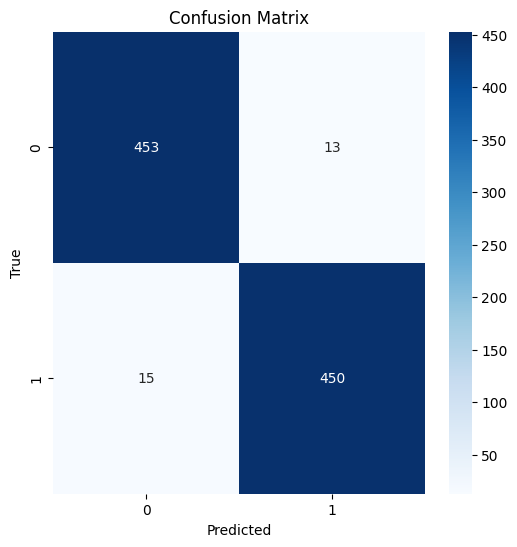

Metrics:
      Metric     Score
0   Accuracy  0.991407
1  Precision  0.971922
2     Recall  0.967742


In [46]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})

# Display Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Metrics:")
print(metrics_df)

# **MLP**

Epoch 1/50
94/94 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 0.8672 - val_loss: 0.1767 - val_accuracy: 0.9303
Epoch 2/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9443 - val_loss: 0.1259 - val_accuracy: 0.9531
Epoch 3/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9584 - val_loss: 0.1138 - val_accuracy: 0.9531
Epoch 4/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.9591 - val_loss: 0.1037 - val_accuracy: 0.9558
Epoch 5/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9678 - val_loss: 0.0959 - val_accuracy: 0.9611
Epoch 6/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9698 - val_loss: 0.0893 - val_accuracy: 0.9611
Epoch 7/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9698 - val_loss: 0.0954 - val_accuracy: 0.9611
Epoch 8/50
94/94 [==

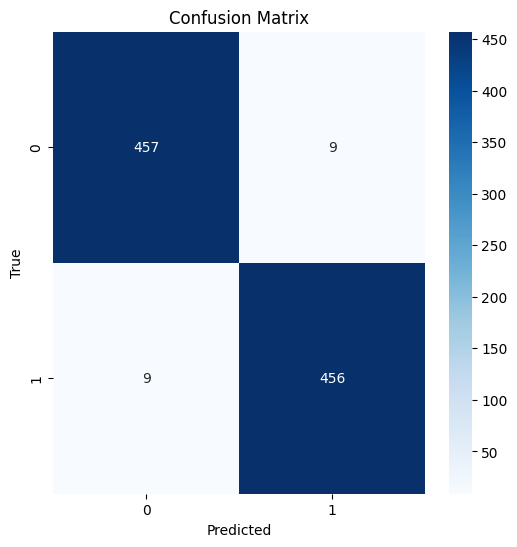

In [47]:
from tensorflow.keras.layers import Dense

# Assuming you have already loaded your data into X_train, y_train, X_test, and y_test
# X_train and X_test have shape (number_of_samples, number_of_features)
# Build the MLP model
MLP = Sequential()
MLP.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
MLP.add(Dense(64, activation='relu'))
MLP.add(Dense(1, activation='sigmoid'))

# Compile the model
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = MLP.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
y_pred_prob = MLP.predict(X_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
models['MLP']=MLP
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Display Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [48]:
from joblib import dump, load
model_filename = 'random_forest_model.joblib'
dump(models[rfc_rfe], model_filename)
print(f"Model saved as {model_filename}")

Model saved as random_forest_model.joblib
